In [1]:
import sklearn
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mnist = fetch_openml("mnist_784", version=1)
X, y = mnist["data"], mnist['target']
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# MNIST with multiclass classification
#### OvA vs OvO

## OvA

In [2]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, np.array(list(map(int, y_train))))   ## auto detect multi class and implement OvA, So 10 bin-classifiers were created


[3]


/home/shay/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


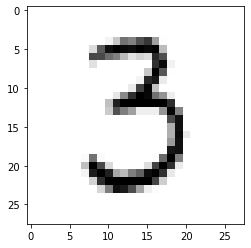

In [17]:
indx = 50
some_digit = X.iloc[indx]
img = np.array(some_digit).reshape(28, 28)


print(sgd_clf.predict([some_digit]))
plt.imshow(img, cmap=mpl.cm.binary)

##### See underlying 10 bin-classifiers scores (OvA)

In [18]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

/home/shay/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-19584.82905069, -18944.92102892,  -7919.67279078,
          6039.69219304,  -9556.93759652,  -1495.61412668,
        -13482.86618687,  -9660.78257371,  -2989.18201979,
        -12452.39783637]])

In [19]:
print(" Pred = " , np.argmax(some_digit_scores))
sgd_clf.classes_

 Pred =  3


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# OvO classifier

In [20]:
from sklearn.multiclass import OneVsOneClassifier
ovo_sgd = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_sgd.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

[0]
Number of models =  45


/home/shay/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


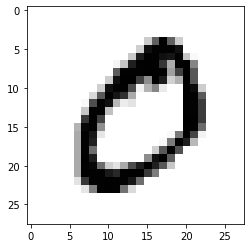

In [29]:
indx = 1
some_digit = X.iloc[indx]
img = np.array(some_digit).reshape(28, 28)

print(sgd_clf.predict([some_digit]))
plt.imshow(img, cmap=mpl.cm.binary)
print("Number of models = " , len(ovo_sgd.estimators_))

# Random Forest : OvA

In [31]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Prediction =  [1]


/home/shay/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/home/shay/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.96, 0.02, 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ]])

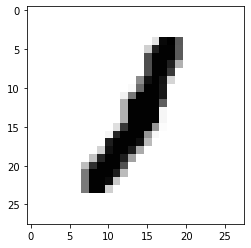

In [42]:
indx = 113
some_digit = X.iloc[indx]
img = np.array(some_digit).reshape(28, 28)

print("Prediction = ", sgd_clf.predict([some_digit]))
plt.imshow(img, cmap=mpl.cm.binary)
forest.predict_proba([some_digit])

# Error Analysis

In [37]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [39]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [43]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [44]:
y_train_pred

array(['3', '0', '4', ..., '5', '6', '8'], dtype='<U1')

Matrix =  [[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


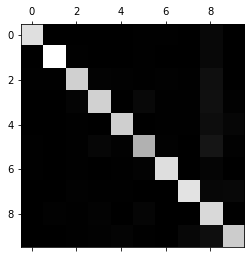

In [51]:
cnf_mtx = confusion_matrix(y_train, y_train_pred)
print("Matrix = ", cnf_mtx)

# plt.matshow(cnf_mtx, cmap=mpl.cm.binary)

plt.matshow(cnf_mtx, cmap=mpl.cm.gray)

In [53]:
# row_wise_sum = cnf_mtx.sum(axis=1)

row_wise_sum = cnf_mtx.sum(axis=1, keepdims=True)
row_wise_sum

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

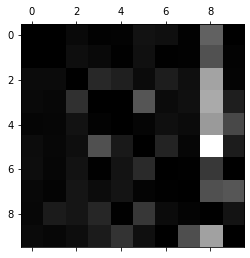

In [58]:
norm_cnf_mat = cnf_mtx/row_wise_sum
np.fill_diagonal(norm_cnf_mat, 0)  # Removed values from mid to see effect clearly
plt.matshow(norm_cnf_mat, cmap=mpl.cm.gray)

## It can be seen 3 and 5 are mis-interpreted. So plot them

In [88]:
def plot_digits(l1, images_per_row=5):
    l1 = np.matrix(l1)

    fig, axs = plt.Subplot(images_per_row, images_per_row)
    axs = axs.flatten()
    for i in range(images_per_row**2):
        axs[i].imshow(l1[i], cmap=mpl.cm.binary)
    return

AttributeError: 'int' object has no attribute 'transSubfigure'

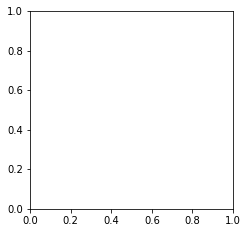

In [89]:
a, b = '3', '5'
X_aa = X_train[(y_train == a) & (y_train_pred == a)]
X_ab = X_train[(y_train == a) & (y_train_pred == b)]
X_ba = X_train[(y_train == b) & (y_train_pred == a)]
X_bb = X_train[(y_train == b) & (y_train_pred == b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25])